In [10]:
import os
import sys

# 現在のディレクトリを取得
current_dir = os.getcwd()

# 一つ前のディレクトリを取得(srcディレクトリへのpathを作成するため)
project_dir = os.path.dirname(current_dir)

# 'src'ディレクトリへのパスを作成
src_dir = os.path.join(project_dir, 'src')

# 'src'ディレクトリのpathをPythonのパスに追加
sys.path.append(src_dir)

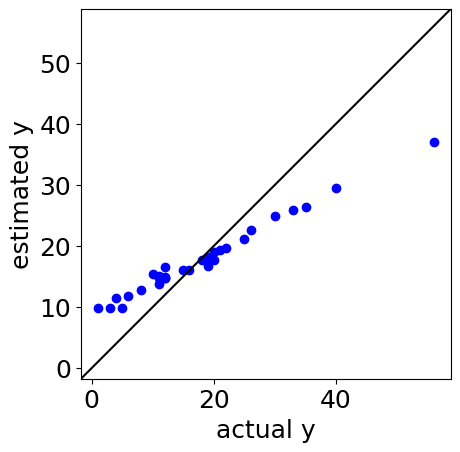

r^2 for training data : 0.752672112513344
RMSE for training data : 5.900724124343347
MAE for training data : 4.573054081652065


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihi

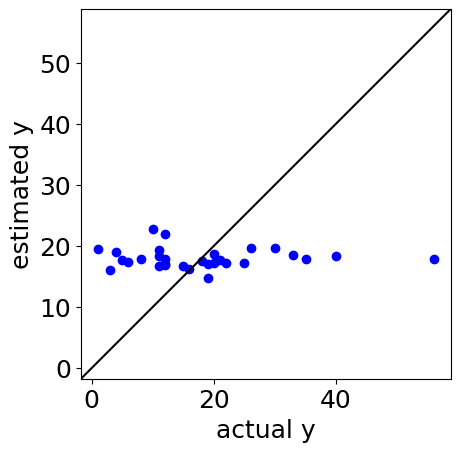

r^2 in cross-validation : -0.026465049885433967
RMSE in cross-validation : 12.021006996343912
MAE in cross-validation : 9.241623414117772
sample number : 1 / 5


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


sample number : 2 / 5
sample number : 3 / 5


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


sample number : 4 / 5
sample number : 5 / 5


In [14]:
import models
import features
import validation
import numpy as np
import pandas as pd

#次の候補の数
number_of_selecting_samples = 5

# 実験結果データの読み込み
dataset = pd.read_csv('./../data/raw/result.csv', index_col=0, header=0)
x_prediction = pd.read_csv('./../data/candidate/remaining_samples.csv', index_col=0, header=0)

# データ分割
y = dataset.iloc[:, 0]  # 目的変数
x = dataset.iloc[:, 1:]  # 説明変数

# 標準偏差が 0 の特徴量の削除
deleting_variables = x.columns[x.std() == 0]
x = x.drop(deleting_variables, axis=1)
x_prediction = x_prediction.drop(deleting_variables, axis=1)
cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化

# ガウス過程回帰(最初にカーネル関数を選択する)
regression_method = 'gpr_one_kernel'
acquisition_function = "PTR" #PTR PI EI MI

cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化
relaxation = 0.01 #EI PI
delta = 10**-6 #MI

next_samples = pd.DataFrame([], columns=x_prediction.columns) # 次のサンプルを入れる変数を準備

for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y = (y - y.mean()) / y.std()
    autoscaled_x = (x - x.mean()) / x.std()
    autoscaled_x_prediction = (x_prediction - x.mean()) / x.std()

    # モデル構築
    model = models.gpr_one_kernel(2,autoscaled_x, autoscaled_y, x)

     # クロスバリデーション
    if sample_number == 0:
        validate = validation.validate_model(regression_method, model,10, autoscaled_x, autoscaled_y, x, y)

    # 予測
    estimated_y_prediction, estimated_y_prediction_std = models.predict(regression_method, model, autoscaled_x_prediction, x_prediction, y)

    estimated_y_prediction, acquisition_function_prediction, acquisition_function = models.acquisition_function(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method)


    # 保存
    estimated_y_prediction = pd.DataFrame(estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction_std = pd.DataFrame(estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    acquisition_function_prediction = pd.DataFrame(acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    if sample_number == 0:
        estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(regression_method))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
        estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
        acquisition_function_prediction.to_csv('acquisition_function_prediction_{0}_{1}.csv'.format(regression_method, acquisition_function))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

    # 次のサンプル
    next_samples = pd.concat([next_samples, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    
    # x, y, x_prediction, cumulative_variance の更新
    x = pd.concat([x, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    y = pd.concat([y, estimated_y_prediction.loc[acquisition_function_prediction.idxmax()].iloc[0]], axis=0)
    x_prediction = x_prediction.drop(acquisition_function_prediction.idxmax(), axis=0)
    cumulative_variance = np.delete(cumulative_variance, np.where(acquisition_function_prediction.index == acquisition_function_prediction.iloc[:, 0].idxmax())[0][0])
    print('sample number : {0} / {1}'.format(sample_number + 1, number_of_selecting_samples))
            
next_samples.to_csv('next_samples_bo_{0}_{1}.csv'.format(regression_method, acquisition_function)) # csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


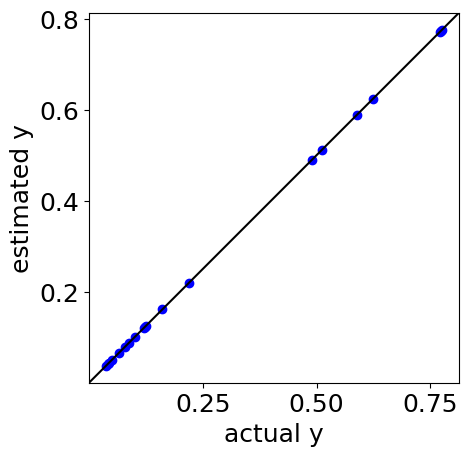

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


r^2 for training data : 0.9999999931263742
RMSE for training data : 2.279078497503e-05
MAE for training data : 1.7018909768481624e-05


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

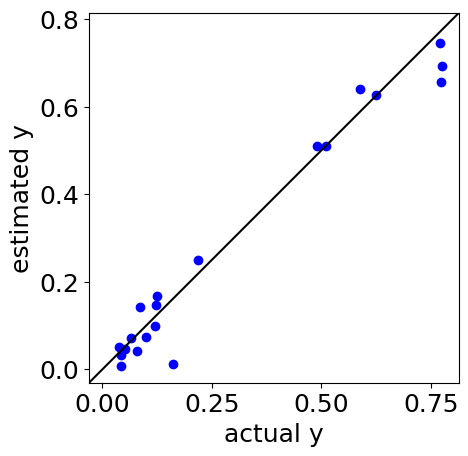

r^2 in cross-validation : 0.9626474051893688
RMSE in cross-validation : 0.053128399189200294
MAE in cross-validation : 0.03772295689551731


In [7]:
import models
import features
import validation

# ガウス過程回帰(最初にカーネル関数を選択する)
regression_method = 'gpr_kernels'
acquisition_function = "PTR" #PTR PI EI MI

relaxation = 0.01 #EI PI
delta = 10**-6 #MI


# 特徴量をモデリングように変換
x,y,autoscaled_x, autoscaled_y, autoscaled_x_prediction, x_prediction= features.build_features(regression_method,'./../data/candidate/remaining_samples.csv','./../data/raw/resin.csv')

# モデル構築
model = models.gpr_one_kernel(2,autoscaled_x, autoscaled_y, x)

# バリデーション
validate = validation.validate_model(regression_method, model,10, autoscaled_x, autoscaled_y, x, y)

# 予測
estimated_y_prediction, estimated_y_prediction_std = models.predict(regression_method, model, autoscaled_x_prediction, x_prediction, y)

estimated_y_prediction, acquisition_function_prediction, acquisition_function = models.acquisition_function(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method)


# 保存
estimated_y_prediction = pd.DataFrame(estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(regression_method))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
estimated_y_prediction_std = pd.DataFrame(estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
acquisition_function_prediction = pd.DataFrame(acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
acquisition_function_prediction.to_csv('acquisition_function_prediction_{0}_{1}.csv'.format(regression_method, acquisition_function))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

# 次のサンプル
next_sample = x_prediction.loc[acquisition_function_prediction.idxmax()]  # 次のサンプル
next_sample.to_csv('next_sample_bo_{0}_{1}.csv'.format(regression_method, acquisition_function)) # csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
